In [ ]:
import os
import cv2
import numpy as np
import pickle
import faiss
from insightface.app import FaceAnalysis

# 📁 Trening rasmlari joylashgan papka
training_path = 'Training_images'

# 💾 Agar indeks allaqachon mavjud bo‘lsa — yuklab olamiz
if os.path.exists("faiss_index.faiss") and os.path.exists("faiss_names.pkl"):
    print("⚡ Faiss indeksi topildi. Yuklanmoqda...")
    index = faiss.read_index("faiss_index.faiss")
    with open("faiss_names.pkl", "rb") as f:
        classNames = pickle.load(f)
    print(f"✅ Yuklandi! Umumiy klasslar soni: {len(classNames)}")

else:
    print("🔧 Yangi Faiss indeksi yaratilmoqda...")
    
    # 🚀 InsightFace modelini yuklash
    model = FaceAnalysis(name='buffalo_l')
    model.prepare(ctx_id=0)  # ⚡ GPU uchun: ctx_id=0 | CPU uchun: ctx_id=-1

    known_embeddings = []
    classNames = []

    # 📌 Har bir rasmni o‘qib embedding ajratamiz
    for file in os.listdir(training_path):
        img_path = os.path.join(training_path, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Fayl ochilmadi: {file}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = model.get(img_rgb)

        if faces:
            emb = faces[0].embedding
            emb = emb / np.linalg.norm(emb)  # 🔁 Kosinus uchun normalize
            known_embeddings.append(emb)
            name = os.path.splitext(file)[0]
            classNames.append(name)
        else:
            print(f"⚠️ Yuz topilmadi: {file}")

    # 🧠 Faiss uchun numpy float32 format
    known_embeddings_np = np.array(known_embeddings).astype('float32')

    # ⚡ Faiss GPU indeksi (cosine similarity uchun)
    dim = known_embeddings_np.shape[1]
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatIP(dim)  # Kosinus uchun
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index_flat)
    gpu_index.add(known_embeddings_np)

    # 💾 Saqlash
    faiss.write_index(faiss.index_gpu_to_cpu(gpu_index), "faiss_index.faiss")
    with open("faiss_names.pkl", "wb") as f:
        pickle.dump(classNames, f)

    print(f"✅ Yangi Faiss indeksi saqlandi! Klasslar soni: {len(classNames)}")


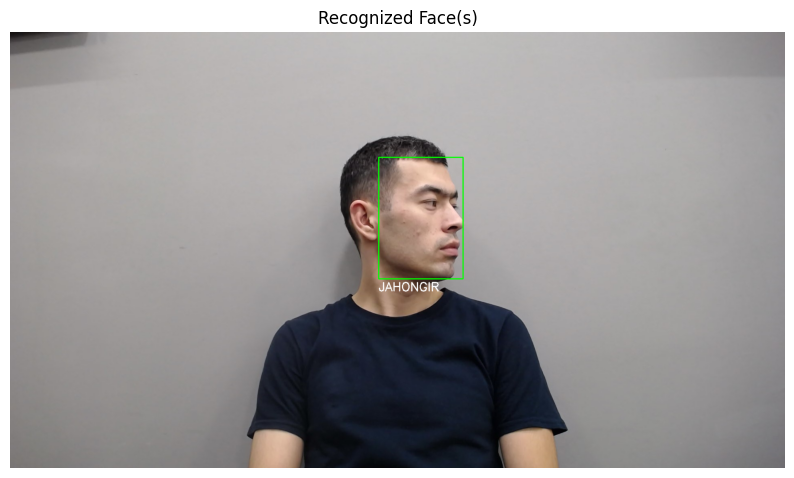

In [ ]:
import cv2
import numpy as np
import pickle
import faiss
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 📥 Faiss indeks va nomlar fayllarini yuklaymiz
index = faiss.read_index("faiss_index.faiss")
with open("faiss_names.pkl", "rb") as f:
    classNames = pickle.load(f)

# ⚡ Faissni GPUga ko‘chirish
res = faiss.StandardGpuResources()
gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

# 🚀 Modelni tayyorlash
model = FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=0)

# 📷 Test rasmni yuklash
test_img = cv2.imread("test3.jpg")
test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
faces = model.get(test_rgb)

# 🔎 Har bir yuzni solishtirish
for face in faces:
    emb = face.embedding
    emb = emb / np.linalg.norm(emb)  # Normalize
    emb = emb.astype('float32').reshape(1, -1)

    D, I = gpu_index.search(emb, k=1)  # Top-1 taqqoslash
    score = D[0][0]
    best_idx = I[0][0]

    if score > 0.5:
        name = classNames[best_idx].upper()
    else:
        name = "UNKNOWN"

    x1, y1, x2, y2 = face.bbox.astype(int)
    cv2.rectangle(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(test_img, name, (x1, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# 🖼️ Natijani chiqarish
clear_output(wait=True)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Yuz tanib olindi")
plt.show()


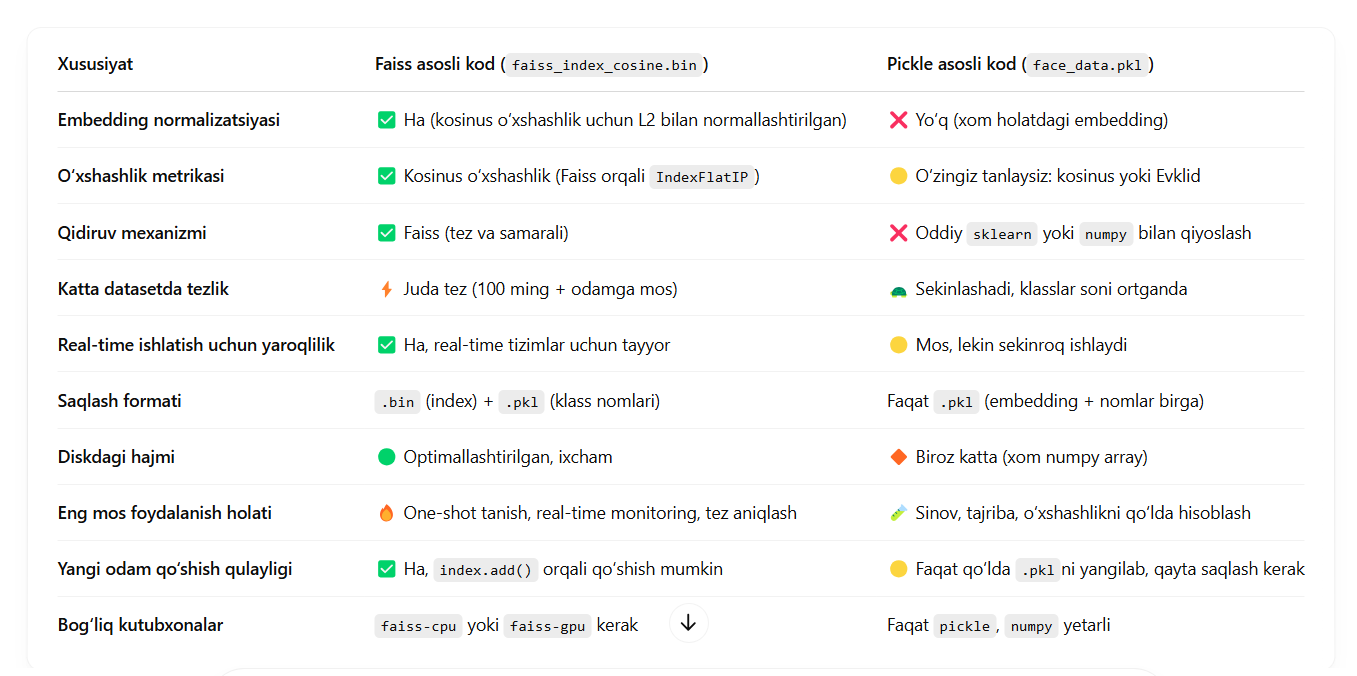

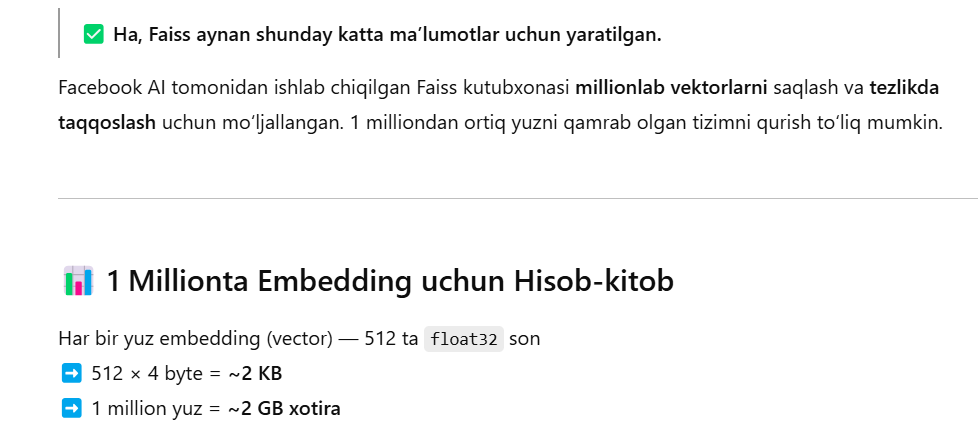

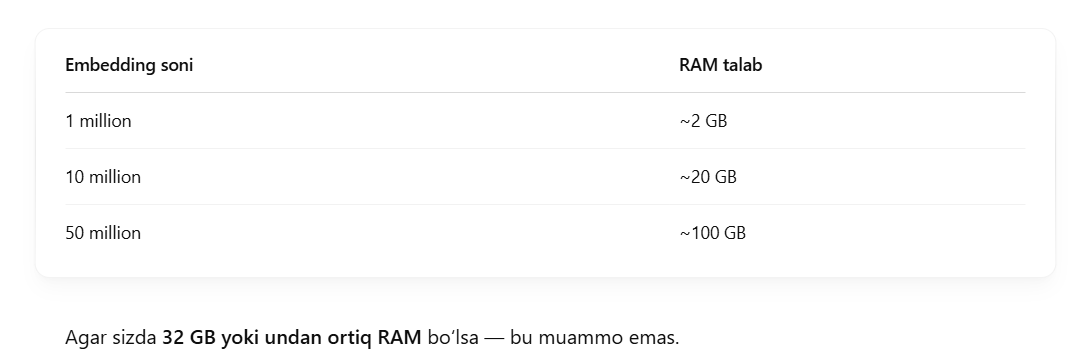

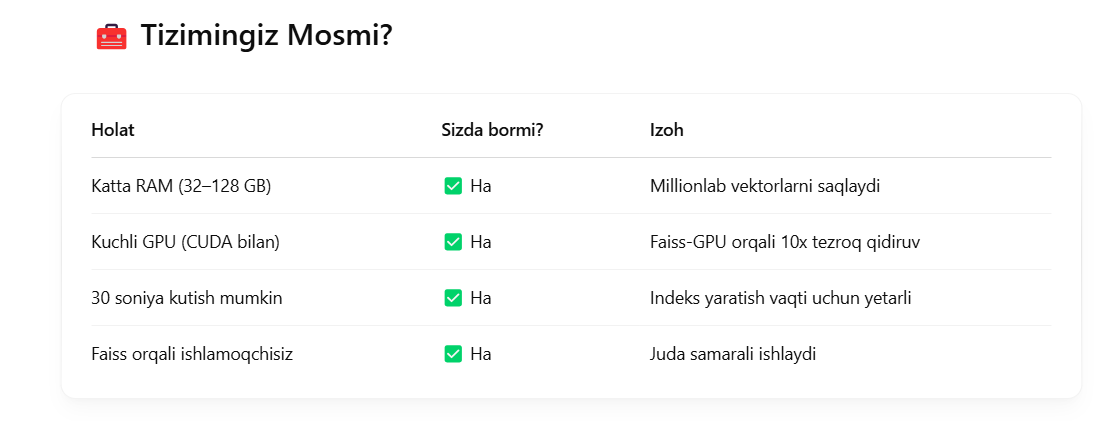

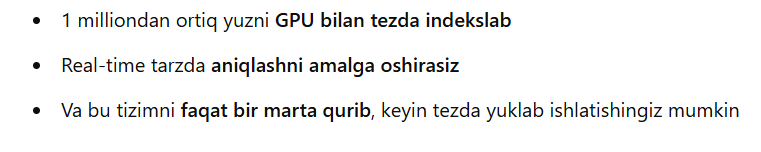